Thanks to [Reference](https://towardsdatascience.com/sentiment-classification-in-python-da31833da01b)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
# Set random seed
seed = 123

# Data manipulation/analysis
import numpy as np
import pandas as pd

# Text preprocessing/analysis
import re
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context='talk')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
sample = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print(f"{sample.shape[0]} rows and {sample.shape[1]} columns")
sample.head()

50000 rows and 2 columns


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
sample['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [18]:
# Encode to numeric
sample['target'] = np.where(sample['sentiment']=='positive', 1, 0)

# Check values
sample.groupby(['sentiment', 'target']).count().unstack()

review         
target           0        1
sentiment                  
negative   25000.0      NaN
positive       NaN  25000.0

In [20]:
# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(sample['review'], sample['target'], test_size=5000, random_state=seed, 
                                                    stratify=sample['sentiment'])

# Append sentiment back using indices
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)#

# Check dimensions
print(f"Train: {train.shape[0]} rows and {train.shape[1]} columns")
print(f"{train['target'].value_counts()}\n")

print(f"Test: {test.shape[0]} rows and {test.shape[1]} columns")
print(test['target'].value_counts())

Train: 45000 rows and 2 columns
1    22500
0    22500
Name: target, dtype: int64

Test: 5000 rows and 2 columns
1    2500
0    2500
Name: target, dtype: int64


In [21]:
train.head()

,review,target
26517,"After watching many of the ""Next Action Star"" ...",0
21812,"I love this movie and all aspects of it, well ...",1
28539,I think I read this someplace: Joe Johnston (d...,1
28984,This movie started out confusing and grew into...,1
34449,I know one is not supposed to comment on other...,1


# Sentiment analysis 

## Sentiment analysis with VADER

In [22]:
example = 'The movie was awesome.'
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(example)

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [23]:
train[['neg', 'neu', 'pos', 'compound']] = train['review'].apply(sid.polarity_scores).apply(pd.Series)
train.head()

,review,target,neg,neu,pos,compound
26517,"After watching many of the ""Next Action Star"" ...",0,0.090,0.798,0.111,0.8869
21812,"I love this movie and all aspects of it, well ...",1,0.080,0.656,0.263,0.9701
28539,I think I read this someplace: Joe Johnston (d...,1,0.034,0.922,0.044,0.4108
28984,This movie started out confusing and grew into...,1,0.130,0.719,0.152,0.4678
34449,I know one is not supposed to comment on other...,1,0.107,0.785,0.107,-0.2535


In [24]:
train.nlargest(5, ['pos'])

,review,target,neg,neu,pos,compound
46615,I smiled through the whole film. The music is ...,1,0.000,0.452,0.548,0.9788
42797,"Great movie, great actors, great soundtrack! I...",1,0.035,0.435,0.531,0.9893
45359,"Great story, great music. A heartwarming love ...",1,0.130,0.342,0.528,0.9612
36819,I LOVE this movie! Beautifully funny and utter...,1,0.000,0.477,0.523,0.9921
39640,The premise is a bit better than the execution...,1,0.000,0.493,0.507,0.9881


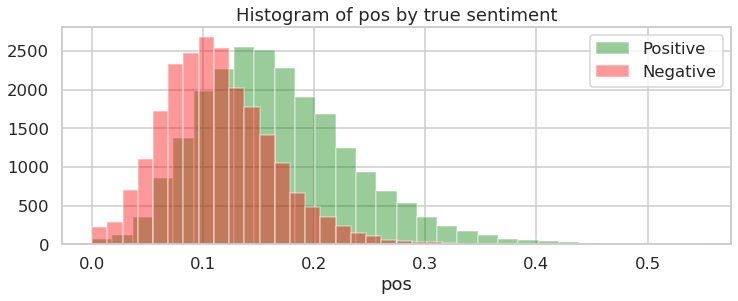

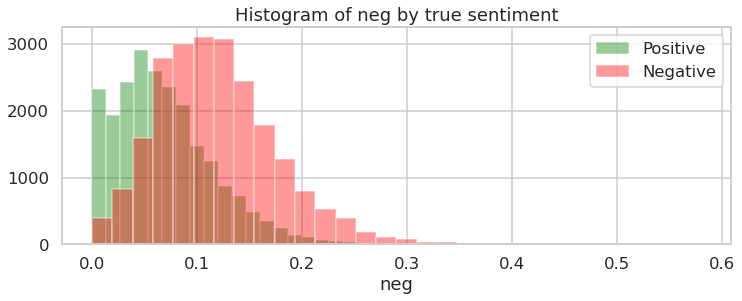

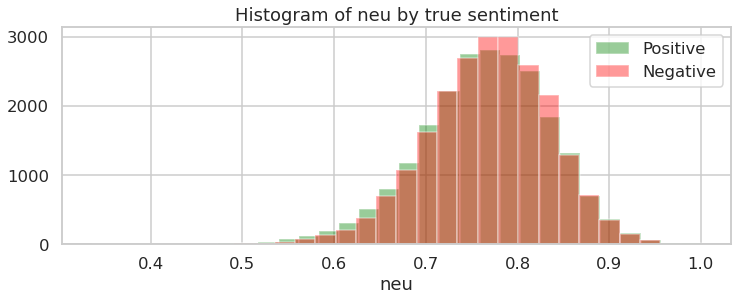

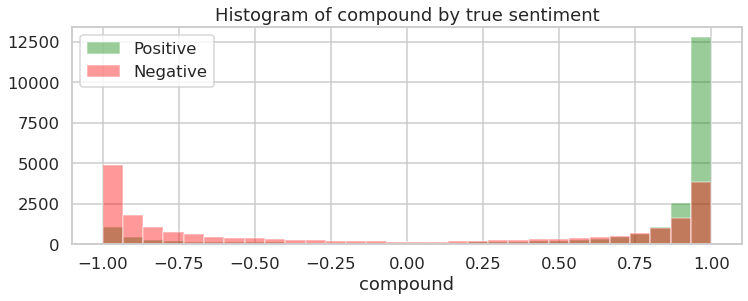

In [25]:
for var in ['pos', 'neg', 'neu', 'compound']:
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("target==1")[var], bins=30, kde=False, 
                 color='green', label='Positive')
    sns.distplot(train.query("target==0")[var], bins=30, kde=False, 
                 color='red', label='Negative')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

In [26]:
train['vader_polarity'] = np.where(train['pos']>train['neg'], 1, 0)
target_names=['negative', 'positive']
print(classification_report(train['target'], 
                            train['vader_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.79      0.52      0.63     22500
    positive       0.64      0.86      0.74     22500

    accuracy                           0.69     45000
   macro avg       0.72      0.69      0.68     45000
weighted avg       0.72      0.69      0.68     45000



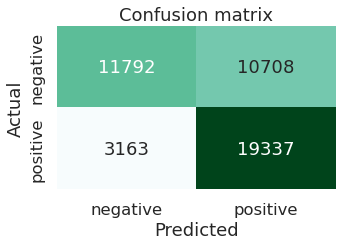

In [27]:
# Create function so that we could reuse later
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});
    
# Plot confusion matrix
plot_cm(train['target'], train['vader_polarity'])

In [28]:
train['vader_compound'] = np.where(train['compound']>0, 1, 0)
print(classification_report(train['target'], 
                            train['vader_compound'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.79      0.53      0.64     22500
    positive       0.65      0.86      0.74     22500

    accuracy                           0.69     45000
   macro avg       0.72      0.69      0.69     45000
weighted avg       0.72      0.69      0.69     45000



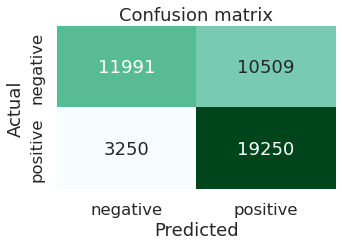

In [29]:
plot_cm(train['target'], train['vader_compound'])

## Sentiment analysis with TextBlob

In [30]:
TextBlob(example).sentiment

Sentiment(polarity=1.0, subjectivity=1.0)

In [31]:
train[['polarity', 'subjectivity']] = train['review'].apply(lambda x:TextBlob(x).sentiment).to_list()

columns = ['review', 'target', 'polarity', 'subjectivity']
train[columns].nlargest(5, ['polarity'])

,review,target,polarity,subjectivity
1440,This was one of my favorites as a child. My fa...,1,1.0,0.80
11996,This movie had me smiling from beginning to en...,1,1.0,0.65
33502,John has made two One man shows. Spic O Rama a...,1,1.0,1.00
39182,Smallville episode Justice is the best episode...,1,1.0,0.65
48927,Smallville episode Justice is the best episode...,1,1.0,0.65


In [32]:
train[columns].nsmallest(5, ['polarity'])

,review,target,polarity,subjectivity
13899,This movie was horrible and corny. James Agee ...,0,-1.000000,1.000000
9775,There are no spoilers for this film as nothing...,0,-0.976562,0.600000
25686,"Sophia Loren plays Aida, in one of the worst f...",0,-0.850000,0.833333
30666,Its a truly awful movie with a laughable story...,0,-0.800000,1.000000
46596,The worst movie i've seen in years (and i've s...,0,-0.800000,0.800000


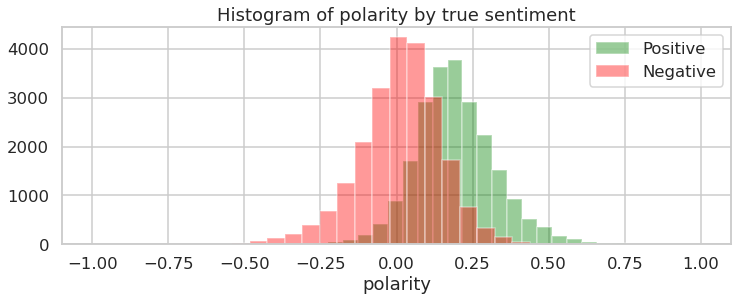

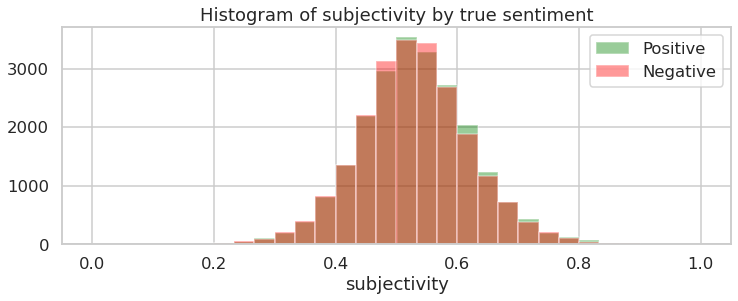

In [33]:
for var in ['polarity', 'subjectivity']:
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("target==1")[var], bins=30, kde=False, 
                 color='green', label='Positive')
    sns.distplot(train.query("target==0")[var], bins=30, kde=False, 
                 color='red', label='Negative')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment');

In [34]:
train['blob_polarity'] = np.where(train['polarity']>0, 1, 0)
print(classification_report(train['target'], 
                            train['blob_polarity'], 
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       0.89      0.43      0.58     22500
    positive       0.62      0.95      0.75     22500

    accuracy                           0.69     45000
   macro avg       0.76      0.69      0.67     45000
weighted avg       0.76      0.69      0.67     45000



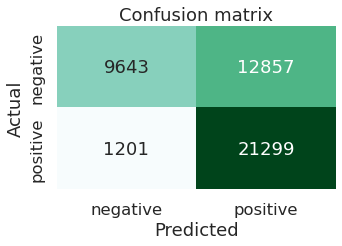

In [35]:
plot_cm(train['target'], train['blob_polarity'])

In [36]:
pd.crosstab(train['vader_polarity'], train['blob_polarity'])

blob_polarity,0,1
vader_polarity,,
0,8152,6803
1,2692,27353


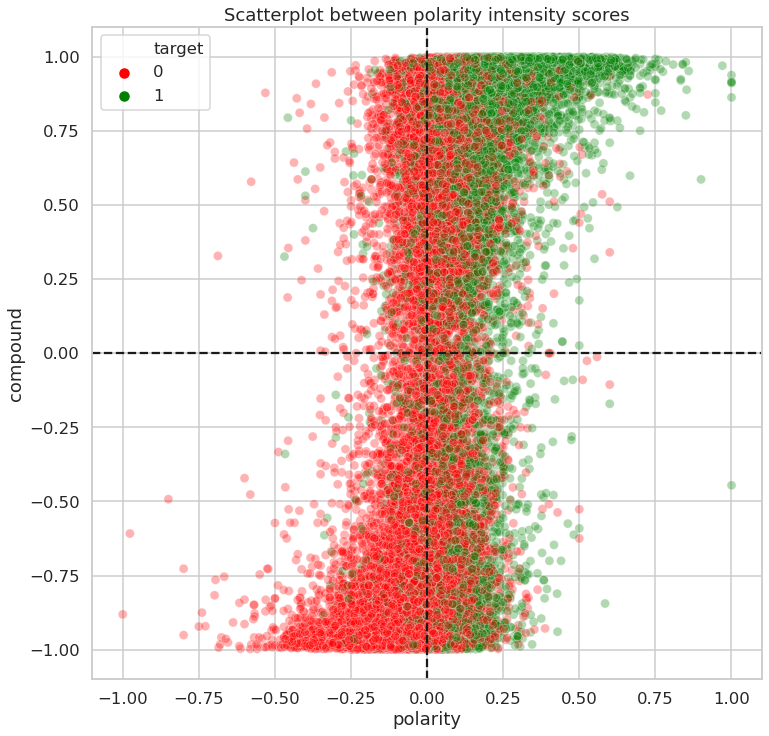

In [37]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=train, x='polarity', y='compound',
                hue='target', palette=['red', 'green'], 
                alpha=.3)
plt.axhline(0, linestyle='--', color='k')
plt.axvline(0, linestyle='--', color='k')
plt.title('Scatterplot between polarity intensity scores');

# Building the models now

In [39]:
# Define functions
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('log', LogisticRegression(random_state=seed, 
                                             max_iter=1000)))
    models.append(('sgd', SGDClassifier(random_state=seed)))
    models.append(('mnb', MultinomialNB()))
    return models

def assess(X, y, models, cv=5, scoring=['roc_auc', 
                                        'accuracy', 
                                        'f1']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                             scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [40]:
models = create_baseline_models()
models

[('log', LogisticRegression(max_iter=1000, random_state=123)),
 ('sgd', SGDClassifier(random_state=123)),
 ('mnb', MultinomialNB())]

In [41]:
# Preprocess the data
vectoriser = TfidfVectorizer(token_pattern=r'[a-z]+', 
                             stop_words='english', 
                             min_df=30, 
                             max_df=.7)
X_train_simpler = vectoriser.fit_transform(X_train)# Assess the model
assess(X_train_simpler, y_train, models)

,log,sgd,mnb
fit_time_mean,1.551091,0.271968,0.038645
fit_time_std,0.323866,0.010143,0.000304
score_time_mean,0.013355,0.013618,0.018123
score_time_std,0.000230,0.000137,0.000235
test_accuracy_mean,0.890511,0.891133,0.856733
test_accuracy_std,0.004160,0.004211,0.003921
test_f1_mean,0.891776,0.892409,0.856632
test_f1_std,0.004462,0.004105,0.004409
test_roc_auc_mean,0.956611,0.956392,0.931120
test_roc_auc_std,0.003067,0.003018,0.003728


In [42]:
# Define function
def preprocess_text(text):
    # 1. Tokenise to alphabetic tokens
    tokeniser = RegexpTokenizer(r'[A-Za-z]+')
    tokens = tokeniser.tokenize(text)
    
    # 2. Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t.lower(), pos='v') 
              for t in tokens]
    return tokens

# Preprocess the data
vectoriser = TfidfVectorizer(analyzer=preprocess_text, 
                             min_df=30, 
                             max_df=.7)
X_train_simple = vectoriser.fit_transform(X_train)

# Assess models
assess(X_train_simple, y_train, models)

,log,sgd,mnb
fit_time_mean,1.641914,0.320056,0.049305
fit_time_std,0.255871,0.016077,0.000579
score_time_mean,0.015899,0.014933,0.020817
score_time_std,0.002765,0.000185,0.000263
test_accuracy_mean,0.891489,0.890156,0.853444
test_accuracy_std,0.004776,0.003925,0.004729
test_f1_mean,0.892568,0.891115,0.852740
test_f1_std,0.004631,0.003470,0.005148
test_roc_auc_mean,0.957976,0.957517,0.928659
test_roc_auc_std,0.002862,0.002639,0.003799


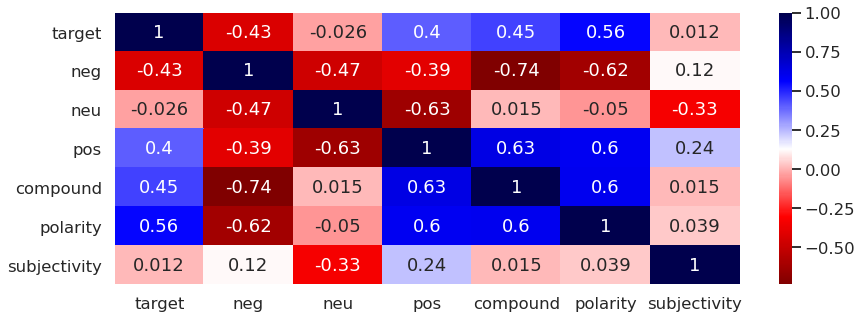

In [43]:
plt.figure(figsize = (14,5))
columns = ['target', 'neg', 'neu', 'pos', 'compound', 'polarity', 
           'subjectivity']
sns.heatmap(train[columns].corr(), annot=True, cmap='seismic_r');

In [44]:
# Initialise a model
sgd = SGDClassifier(random_state=seed)# Initialise a scaler
scaler = MinMaxScaler()# Assess the model using scores
scores = train[['neg', 'neu', 'pos', 'compound', 'polarity', 
                'subjectivity']]
assess(scaler.fit_transform(scores), y_train, [('sgd', sgd)])

,sgd
fit_time_mean,0.065915
fit_time_std,0.009316
score_time_mean,0.010751
score_time_std,0.000879
test_accuracy_mean,0.769844
test_accuracy_std,0.006400
test_f1_mean,0.772617
test_f1_std,0.009789
test_roc_auc_mean,0.847807
test_roc_auc_std,0.006098


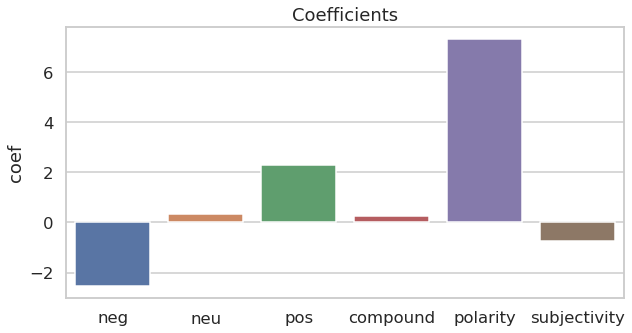

In [45]:
# Fit to training data
sgd.fit(scores, y_train)# Get coefficients
coefs = pd.DataFrame(data=sgd.coef_, columns=scores.columns).T
coefs.rename(columns={0: 'coef'}, inplace=True)# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=coefs.index, y='coef', data=coefs)
plt.title('Coefficients');

In [46]:
# Add features to sparse matrix
selected_scores = train[['neg', 'pos', 'polarity']]
X_train_extended = hstack([X_train_simpler, csr_matrix(scaler.fit_transform(selected_scores))])

# Assess
assess(X_train_extended, y_train, [('sgd', sgd)])

,sgd
fit_time_mean,0.295018
fit_time_std,0.025069
score_time_mean,0.013829
score_time_std,0.000208
test_accuracy_mean,0.888933
test_accuracy_std,0.003787
test_f1_mean,0.888938
test_f1_std,0.004412
test_roc_auc_mean,0.955578
test_roc_auc_std,0.002394


In [ ]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+')),
                 ('model', SGDClassifier(random_state=seed))])

# Prepare a random search
param_distributions = {'vectoriser__min_df': np.arange(10, 1000, 10),
                       'vectoriser__max_df': np.linspace(.2, 1, 40),
                       'model__loss': ['log', 'hinge']}
r_search = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, 
                              n_iter=30, cv=5, n_jobs=-1, random_state=seed)
r_search.fit(X_train, y_train)

# Save results to a dataframe
r_search_results = pd.DataFrame(r_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
columns = [col for col in r_search_results.columns 
           if re.search(r"split|param_", col)]
r_summary = r_search_results[columns].copy()
r_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in r_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in r_summary.columns ]
r_summary.columns = columns
r_summary.head()

In [ ]:
# Create a long dataframe
r_summary_long = pd.melt(r_summary, 
                         id_vars=['min_df', 
                                  'max_df', 
                                  'loss'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])# Plot hyperparameter 'loss'
plt.figure(figsize=(8,4))
plt.title('Performance by loss')
sns.boxplot(x='value', y='loss', data=r_summary_long, 
            orient='h')
plt.xlim(.8, .9);

In [ ]:
for param in ['min_df', 'max_df']:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=param, y="value", data=r_summary_long, 
                    x_jitter=True, alpha=0.5)
    plt.ylim(.8, .9);

In [ ]:
# Create a pipeline
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', max_df=.6)),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])

# Prepare a grid search
param_grid = {'vectoriser__min_df': [30, 90, 150],
              'vectoriser__ngram_range': [(1,1), (1,2)],
              'vectoriser__stop_words': [None, 'english'],
              'model__fit_intercept': [True, False]}
g_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, n_jobs=-1)
g_search.fit(X_train, y_train)

# Save results to a dataframe
g_search_results = pd.DataFrame(g_search.cv_results_).sort_values(by='rank_test_score')

In [ ]:
columns = [col for col in g_search_results.columns 
           if re.search(r"split|param_", col)]
g_summary = g_search_results[columns+['mean_test_score']].copy()
g_summary.columns = [re.sub(r'_test_score|param_', '', col) 
                     for col in g_summary.columns]
columns = [col.split('__')[1] if '__' in col else col 
           for col in g_summary.columns ]
g_summary.columns = columns
g_summary.head()

In [ ]:
# Create a long dataframe
g_summary_long = pd.melt(g_summary, 
                         id_vars=['min_df', 
                                  'ngram_range', 
                                  'stop_words', 
                                  'fit_intercept'], 
                         value_vars=['split0', 
                                     'split1', 
                                     'split2', 
                                     'split3', 
                                     'split4'])
g_summary_long.replace({None: 'None'}, inplace=True)

# Plot performance
for param in ['ngram_range', 'stop_words', 'fit_intercept']:
    plt.figure(figsize=(8,4))
    plt.title(f'Performance by {param}')
    sns.boxplot(x='value', y=param, data=g_summary_long, orient='h')
    plt.xlim(.85, .95);

In [ ]:
pipe = Pipeline([('vectoriser', TfidfVectorizer(token_pattern=r'[a-z]+', min_df=30, max_df=.6, ngram_range=(1,2))),
                 ('model', SGDClassifier(random_state=seed, loss='hinge'))])

pipe.fit(X_train, y_train)

In [ ]:
coefs = pd.DataFrame(pipe['model'].coef_, 
                     columns=pipe['vectoriser'].get_feature_names())
coefs = coefs.T.rename(columns={0:'coef'}).sort_values('coef')
coefs

In [ ]:
train_pred = pipe.predict(X_train)
print(classification_report(train_pred, 
                            y_train, 
                            target_names=target_names))

In [ ]:
test_pred = pipe.predict(X_test)
print(classification_report(test_pred, 
                            y_test, 
                            target_names=target_names))

In [ ]:
plot_cm(test_pred, y_test, target_names=target_names)

In [ ]:
for i in range(10):
    lead = X_test.sample(1)
    %timeit pipe.predict(lead)